In [1]:
using ConvDiff
using PyPlot
using jInv.Mesh
using jInv.ForwardShare
using jInv.InverseSolve
using jInvVis
using jInv.LinearSolvers
using MAT

## Read problem description

We load the description of the domain, velocity, viscocity, as well as the observed data and the receiver locations from a MAT file. Note that we do not load the true model at this point. 

In [7]:
# filename= "2DmodelLShaped.mat"
filename= "Peaks2D.mat"
file = matread(filename)

# problem description
domain = file["domain"]
v      = file["v"]
sig    = file["sig"]

# data and receiver location
dtrue  = file["dtrue"]
rec    = file["rec"];

dnoise = randn(size(dtrue));
dnoise /= norm(dnoise)
dnoise *= 0.1*norm(dtrue)
dobs = dtrue + dnoise


200-element Array{Float64,1}:
  0.0380232  
  0.000201526
  0.0318498  
 -0.00259541 
  0.234996   
 -0.00703258 
  0.231068   
  0.167851   
  0.0460458  
  0.205463   
  0.122787   
  0.220522   
 -0.00777    
  ⋮          
  0.127378   
  0.246761   
  0.188441   
  0.223018   
  0.0287677  
  0.22084    
  0.127409   
  0.221927   
  0.0935613  
  0.265074   
  0.0875421  
  0.17585    

# Setup Forward Problem

To set up the forward problem, we need to pick a mesh to dirscretize the PDE operators, a discretization method (here FEM) and we also need to discretize the measurement matrix. Since the receiver locations are, generally, at off-grid points we build a bi-linear interpolation matrix that estimates the PDE solution at those locations. 

In [8]:
M = getRegularMesh(domain,[256 128]);

# build linear interpolation matrix from nodes to receiver locations
x1,x2 = getNodalAxes(M)
P = interpmat(x1,x2, rec);

pFor = getConvDiffFEMParam(M,v=v,sig=sig,P=P,Ainv=getMUMPSsolver());

# Setup Inverse Problem


We set up the relaxed formulation of the inverse problem. To this end, we need to configure the misfit function, select a regularizer, and choose some optimization paramters.

In [14]:
## configure misfit
Wt         = ones(size(dobs))      
sigback    = 0.0
pMis       = getMisfitParam(pFor,Wt,dobs,SSDFun) 
	
## Configure regularization
mref       = zeros(M.nc)           
alpha      = 5e-3
# reg        = (m,mr,M,I=1.0) -> anisoTVReg(m,mr,M,eps=1e-8)  
reg        = (m,mr,M,I=1.0) -> wTVReg(m,mr,M,eps=1e-8)  
	
## Configure optimization
maxIter    = 50
minUpdate  = 1e-3
HesPrec    = getSSORRegularizationPreconditioner(1.0,1e-15,50)
cgit       = 5 
pcgTol     = 1e-1
modFun     = identityMod
boundsLow  = 0*ones(M.nc)
boundsHigh = 1*ones(M.nc)
maxStep	   = 0.1*maximum(boundsHigh)

## store the configuration 
pInv       = getInverseParam(M,modFun,reg,alpha,mref,
                             boundsLow,boundsHigh,maxStep=maxStep,
                            pcgMaxIter=cgit,pcgTol=pcgTol,minUpdate=minUpdate,maxIter=maxIter,
                            HesPrec=HesPrec);
	


# Run Inversion

In [15]:
mc,Dc,flag,His = projGNCG(mref+0.1,pInv,pMis)
uc = pFor.Fields;          # u variables
wr = pInv.modelfun(mc)[1]; # w variables



 i.LS	       F	       R	alpha[1]	   Jc/J0	 #Active
  1.0	7.21e-01	2.12e-03	5.00e-03	1.00e+00	  0
   .1	7.10e-01	2.14e-03			9.84e-01
  2.0	7.10e-01	2.14e-03	5.00e-03	9.84e-01	  1
   .1	5.22e-01	2.63e-03			7.25e-01
  3.0	5.22e-01	2.63e-03	5.00e-03	7.25e-01	  2
   .1	3.31e-01	3.49e-03			4.62e-01
  4.0	3.31e-01	3.49e-03	5.00e-03	4.62e-01	  2
   .1	2.26e-01	4.23e-03			3.18e-01
  5.0	2.26e-01	4.23e-03	5.00e-03	3.18e-01	  2
   .1	1.52e-01	4.96e-03			2.17e-01
  6.0	1.52e-01	4.96e-03	5.00e-03	2.17e-01	  2
   .1	1.04e-01	5.65e-03			1.52e-01
  7.0	1.04e-01	5.65e-03	5.00e-03	1.52e-01	925
   .1	7.43e-02	6.28e-03			1.11e-01
  8.0	7.43e-02	6.28e-03	5.00e-03	1.11e-01	2044
   .1	5.56e-02	6.80e-03			8.63e-02
  9.0	5.56e-02	6.80e-03	5.00e-03	8.63e-02	3359
   .1	4.18e-02	7.30e-03			6.80e-02
 10.0	4.18e-02	7.30e-03	5.00e-03	6.80e-02	4852
   .1	3.35e-02	7.76e-03			5.71e-02
 11.0	3.35e-02	7.76e-03	5.00e-03	5.71e-02	7073
   .1	2.81e-02	8.20e-03			5.02e-02
 12.0	2.81e-02	8.20e-03	5.00e-03	5.02e-02	7683
   .1	

## Visualize Results

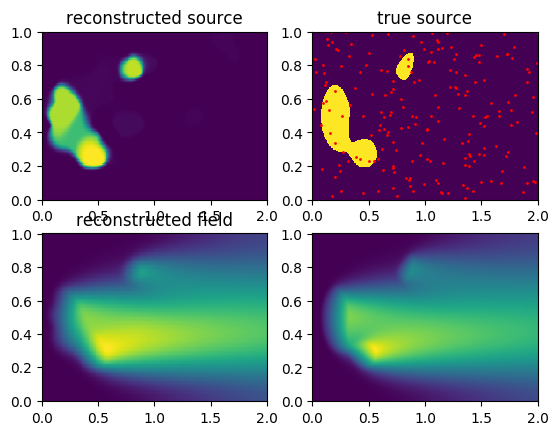

PyObject <matplotlib.collections.QuadMesh object at 0x131f131d0>

In [16]:
subplot(2,2,1)
viewImage2D(wr,M)
title("reconstructed source")
subplot(2,2,2)
viewImage2D(vec(file["W"]),getRegularMesh(domain,file["m"]));
plot(rec[:,1],rec[:,2],"or",MarkerSize=1)
title("true source")


subplot(2,2,3)
viewImage2D(uc,getPaddedMesh(M))
title("reconstructed field")

subplot(2,2,4)
viewImage2D(vec(file["utrue"]),getPaddedMesh(getRegularMesh(domain,file["m"])))


(200, 2)